<a href="https://colab.research.google.com/github/Hugo-MR/Hugo-MR/blob/main/PROYECTO_ALQUILER_MADRID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este proyecto de Machine Learning tiene como objetivo desarrollar un modelo predictivo capaz de estimar el precio de alquiler de una vivienda en Madrid en función de sus características. Utilizando técnicas de aprendizaje automático implementadas en Python, se analizarán datos recopilados del portale inmobiliario 'elidealista.com' para identificar patrones y relaciones entre las variables que afectan el precio. Nos basaremos en su geolocalizacion para tratar de determinar patrones o comportamientos interesantes. El modelo resultante permitirá a los usuarios obtener estimaciones confiables del precio de mercado de una propiedad específica, facilitando la toma de decisiones informadas en el proceso de compra o venta. Además, este estudio proporcionará información valiosa sobre las tendencias y factores clave que impulsan los precios de las viviendas en la capital española.

El análisis se realizará en varias etapas, comenzando con la recolección y preparación de los datos, seguido del análisis exploratorio y la visualización de los mismos. Posteriormente, se procederá a la selección y entrenamiento de los modelos predictivos, para finalmente evaluar su desempeño y realizar ajustes necesarios. Este enfoque permitirá identificar las características más influyentes en la determinación del precio de alquiler de las viviendas y proporcionar una herramienta útil para compradores, vendedores e inversores en el mercado inmobiliario Madrileño.

In [ ]:
# Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

import folium
from folium import Choropleth, Circle, Marker, Icon, Map, GeoJson
from folium.plugins import HeatMap, MarkerCluster


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [ ]:
# importamos el archivo

df = pd.read_csv('/content/idealista_api_rent_madrid.csv')

In [ ]:
# forma

df.shape

(450, 40)

In [ ]:
df.head(3)

,propertyCode,thumbnail,numPhotos,price,propertyType,operation,size,exterior,rooms,bathrooms,...,superTopHighlight,topNewDevelopment,externalReference,floor,district,neighborhood,hasLift,parkingSpace,labels,newDevelopmentFinished
0,98903350,https://img3.idealista.com/blur/WEB_LISTING/0/...,33,550.0,chalet,rent,371.0,False,6,3,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,91615378,https://img3.idealista.com/blur/WEB_LISTING/0/...,12,750.0,flat,rent,60.0,True,1,1,...,False,False,AV23,3,Hortaleza,Canillas,True,NaN,NaN,NaN
2,88363329,https://img3.idealista.com/blur/WEB_LISTING/0/...,21,750.0,flat,rent,70.0,True,2,1,...,False,False,NaN,bj,Centro Urbano,NaN,False,NaN,NaN,NaN


### **ESTUDIO Y LIMPIEZA DE LOS DATOS**

In [ ]:
# columnas

df.columns

Index(['propertyCode', 'thumbnail', 'numPhotos', 'price', 'propertyType',
       'operation', 'size', 'exterior', 'rooms', 'bathrooms', 'address',
       'province', 'municipality', 'country', 'latitude', 'longitude',
       'showAddress', 'url', 'distance', 'description', 'hasVideo', 'status',
       'newDevelopment', 'priceByArea', 'detailedType', 'suggestedTexts',
       'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight',
       'topNewDevelopment', 'externalReference', 'floor', 'district',
       'neighborhood', 'hasLift', 'parkingSpace', 'labels',
       'newDevelopmentFinished'],
      dtype='object')

In [ ]:
# valores nulos

df.isnull().sum()

propertyCode                0
thumbnail                   1
numPhotos                   0
price                       0
propertyType                0
operation                   0
size                        0
exterior                    0
rooms                       0
bathrooms                   0
address                     0
province                    0
municipality                0
country                     0
latitude                    0
longitude                   0
showAddress                 0
url                         0
distance                    0
description                 1
hasVideo                    0
status                      0
newDevelopment              0
priceByArea                 0
detailedType                0
suggestedTexts              0
hasPlan                     0
has3DTour                   0
has360                      0
hasStaging                  0
superTopHighlight           0
topNewDevelopment           0
externalReference          92
floor     

Elimino las columnas no relevantes para el estudio.

Elimino tambien las columnas de direccion, provincia, pais, puesto que ya tengo su ubicacion en latitud y longitud.

In [ ]:
df_limpio = df.drop(['thumbnail', 'showAddress', 'url','distance', 'description', 'hasVideo', 'suggestedTexts',
              'hasPlan', 'has3DTour', 'has360', 'hasStaging', 'superTopHighlight', 'topNewDevelopment',
              'floor', 'district', 'neighborhood', 'labels', 'newDevelopmentFinished', 'externalReference',
              'address', 'province', 'country'],axis=1)

In [ ]:
df_limpio.shape

(450, 18)

In [ ]:
df_limpio.isnull().sum()

propertyCode        0
numPhotos           0
price               0
propertyType        0
operation           0
size                0
exterior            0
rooms               0
bathrooms           0
municipality        0
latitude            0
longitude           0
status              0
newDevelopment      0
priceByArea         0
detailedType        0
hasLift            13
parkingSpace      303
dtype: int64

Vemos que hay valores nulos en la columna 'parkingSpace' y 'hasLift'

In [ ]:
# parkingSpace

# posibles elementos para la culumna 'parkingSpace'

df_limpio['parkingSpace'].unique()

array([nan,
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 50.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 40.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 90.0}",
       "{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 15000.0}"],
      dtype=object)

Podemos observar que solo tiene valores NaN y True, por lo que podemos entender que todos los valores NaN son False.

Esta columna se divide en True y False (si tienen garaje o no), y a su vez los que son True, se dividen en los que el precio esta incluido y los que no.

Vamos a estudiar estos datos.

In [ ]:
df_limpio['parkingSpace'].value_counts()

parkingSpace
{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': True}                                   143
{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 50.0}         1
{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 40.0}         1
{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 90.0}         1
{'hasParkingSpace': True, 'isParkingSpaceIncludedInPrice': False, 'parkingSpacePrice': 15000.0}      1
Name: count, dtype: int64

Vemos que solo hay 4 valores en los que el precio no esta includido. Vamos a incluirlo, para simplificar la columna 'parkingSpace' y tener valores False; para los que no tienen parking y True; para los que si tienen y su precio esta incluido

En uno de los casos el precio es demasiado elevado respecto a la media. Vamos a estudiarlo.

In [ ]:
# caso 15000

fila_parking_15000 = df_limpio[df_limpio['ParkingPrice'] == 15000]

print(fila_parking_15000)

     propertyCode  numPhotos  price propertyType operation  size  exterior  \
352      98915091         11  750.0         flat      rent  70.0      True   

     rooms  bathrooms municipality   latitude  longitude status  \
352      2          1     Alcorcón  40.346885  -3.820639   good   

     newDevelopment  priceByArea          detailedType hasLift  parkingSpace  \
352           False         11.0  {'typology': 'flat'}   False          True   

     hasParking  ParkingPrice  
352        True       15000.0  


Estudiando el enlace de esta vivienda, vemos que el precio es un error y su precio real son 150

In [ ]:
df_limpio.loc[[107, 127, 295, 352], 'price']

107    750.0
127    640.0
295    700.0
352    750.0
Name: price, dtype: float64

ID  ---> Precio a sumar. Precio original

107 ---> 50 €      .precio = 750 €

127 ---> 40 €      .precio = 640 €

295 ---> 90 €      .precio = 700 €

352 ---> 150 €     .precio = 750 €

In [ ]:
# sumo lo valores anteriores a las filas indicadas

sumas = {
    107: 50,
    127: 40,
    295: 90,
    352: 150
}

# Sumar las cantidades especificadas a la columna 'Price' en las filas correspondientes
for fila, cantidad in sumas.items():
    df_limpio.loc[fila, 'price'] += cantidad


In [ ]:
df_limpio.loc[[107, 127, 295, 352], 'price']

,price
107,800.0
127,680.0
295,790.0
352,900.0


Una vez simplificada la columna 'parkingSpace' Sustituyo los valores nulos por False, y el resto por True

In [ ]:
df_limpio['parkingSpace'] = df_limpio['parkingSpace'].apply(lambda x: False if pd.isna(x) else True)


df_limpio['parkingSpace'].value_counts()

,count
parkingSpace,
False,303
True,147


Ya tenemos la columna 'parkingSpace' con valores booleanos, si tiene parking o no y los que si tienen, su precio esta incluido en el precio de alquiler

In [ ]:
# Valores nulos

df_limpio.isnull().sum()

propertyCode       0
numPhotos          0
price              0
propertyType       0
operation          0
size               0
exterior           0
rooms              0
bathrooms          0
municipality       0
latitude           0
longitude          0
status             0
newDevelopment     0
priceByArea        0
detailedType       0
hasLift           13
parkingSpace       0
dtype: int64

Seguimos limpiando los datos en la columna 'hasLift'

In [ ]:
# hasLift

# posibles elementos para la culumna 'hasLift'

df_limpio['hasLift'].unique()

array([nan, True, False], dtype=object)

In [ ]:
# que filas tienen NaN en su columna 'hasLift'

hasLift_nan = df[df['hasLift'].isna()]

hasLift_nan.head()

,propertyCode,thumbnail,numPhotos,price,propertyType,operation,size,exterior,rooms,bathrooms,...,superTopHighlight,topNewDevelopment,externalReference,floor,district,neighborhood,hasLift,parkingSpace,labels,newDevelopmentFinished
0,98903350,https://img3.idealista.com/blur/WEB_LISTING/0/...,33,550.0,chalet,rent,371.0,False,6,3,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,98565606,https://img3.idealista.com/blur/WEB_LISTING/0/...,15,650.0,chalet,rent,206.0,False,3,1,...,False,False,MAYORBIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,98936559,https://img3.idealista.com/blur/WEB_LISTING/0/...,27,750.0,chalet,rent,130.0,False,4,1,...,False,False,00505,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,98933397,https://img3.idealista.com/blur/WEB_LISTING/0/...,17,700.0,flat,rent,230.0,True,4,2,...,False,False,PIS_322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,95733257,https://img3.idealista.com/blur/WEB_LISTING/0/...,19,600.0,flat,rent,90.0,False,3,2,...,False,False,ISA-9061,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vamos a sacar el 'url', de todas las filas cuyo 'hasLift' es NaN, para comprobarlo por separado.

In [ ]:
# 'url' para valores nulos

enlace_lift_nan = df[df['hasLift'].isna()]['url']
print(enlace_lift_nan)



0      https://www.idealista.com/inmueble/98903350/
23     https://www.idealista.com/inmueble/98565606/
64     https://www.idealista.com/inmueble/98936559/
71     https://www.idealista.com/inmueble/98933397/
155    https://www.idealista.com/inmueble/95733257/
162    https://www.idealista.com/inmueble/98908680/
237    https://www.idealista.com/inmueble/98854687/
264    https://www.idealista.com/inmueble/98781973/
296    https://www.idealista.com/inmueble/94184603/
317    https://www.idealista.com/inmueble/86955129/
371    https://www.idealista.com/inmueble/96152026/
406    https://www.idealista.com/inmueble/98719654/
415    https://www.idealista.com/inmueble/98264932/
Name: url, dtype: object


Tras comprobar todos los encaces, ninguno de ellos tiene ascensor, luego sustituyo los valores NaN por False

In [ ]:
# sustituyo los valores NaN por False

df_limpio['hasLift'].fillna(False, inplace=True)

In [ ]:
df_limpio.isnull().sum()

,0
propertyCode,0
numPhotos,0
price,0
propertyType,0
operation,0
size,0
exterior,0
rooms,0
bathrooms,0
municipality,0


Nuestros datos ya no tienen valores nulos.

In [ ]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   propertyCode    450 non-null    int64  
 1   numPhotos       450 non-null    int64  
 2   price           450 non-null    float64
 3   propertyType    450 non-null    object 
 4   operation       450 non-null    object 
 5   size            450 non-null    float64
 6   exterior        450 non-null    bool   
 7   rooms           450 non-null    int64  
 8   bathrooms       450 non-null    int64  
 9   municipality    450 non-null    object 
 10  latitude        450 non-null    float64
 11  longitude       450 non-null    float64
 12  status          450 non-null    object 
 13  newDevelopment  450 non-null    bool   
 14  priceByArea     450 non-null    float64
 15  detailedType    450 non-null    object 
 16  hasLift         450 non-null    bool   
 17  parkingSpace    450 non-null    boo

Un poco de informacion sobre el numero total, la media, valores maximos y minimos, etc...

In [ ]:
df_limpio.describe()

,propertyCode,numPhotos,price,size,rooms,bathrooms,latitude,longitude,priceByArea
count,4.500000e+02,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,9.463515e+07,21.900000,671.797778,68.237778,1.700000,1.213333,40.388244,-3.695993,11.875556
std,1.385817e+07,9.670346,85.100603,35.662557,0.970041,0.441500,0.183371,0.226782,5.395088
min,6.666960e+05,0.000000,340.000000,20.000000,0.000000,1.000000,39.933288,-4.334495,1.000000
25%,9.756495e+07,15.000000,640.000000,47.250000,1.000000,1.000000,40.300117,-3.777188,8.000000
50%,9.866032e+07,21.000000,700.000000,62.000000,2.000000,1.000000,40.406238,-3.695364,11.000000
75%,9.889432e+07,28.000000,740.000000,80.000000,2.000000,1.000000,40.481070,-3.601154,15.000000
max,9.893968e+07,72.000000,750.000000,371.000000,6.000000,3.000000,40.907397,-3.106727,33.000000


## **VISULIZACION E INTERPRETACION DE LOS DATOS**

Vamos a crear algunos graficos que nos ayuden a obtener mas informacion.

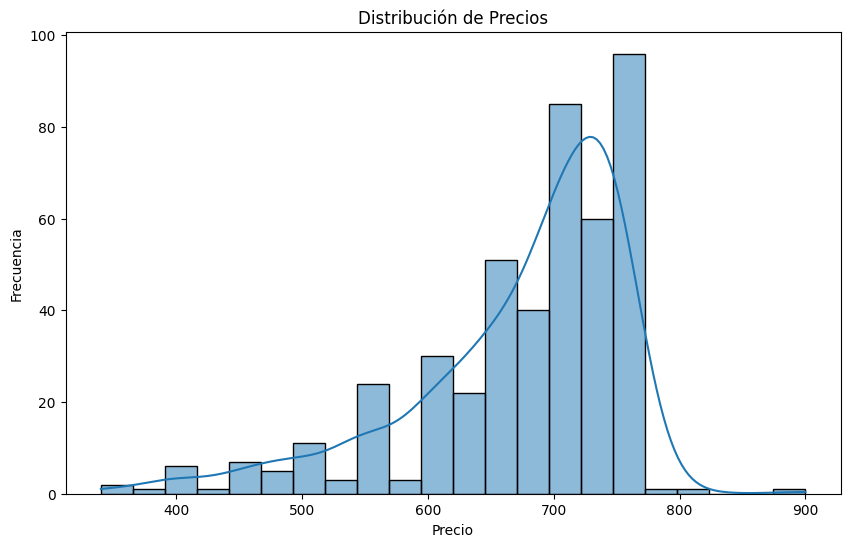

In [ ]:
# Distribución de Precios

plt.figure(figsize=(10, 6))
sns.histplot(df_limpio['price'], kde=True)
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

En este grafico de distribución de precios podemos ver que la mayor concentración de precios se encuentra entre 600 y 800 €. La mayoría de los precios se agrupan alrededor de los 700-750 €, mostrando una clara moda en este rango.

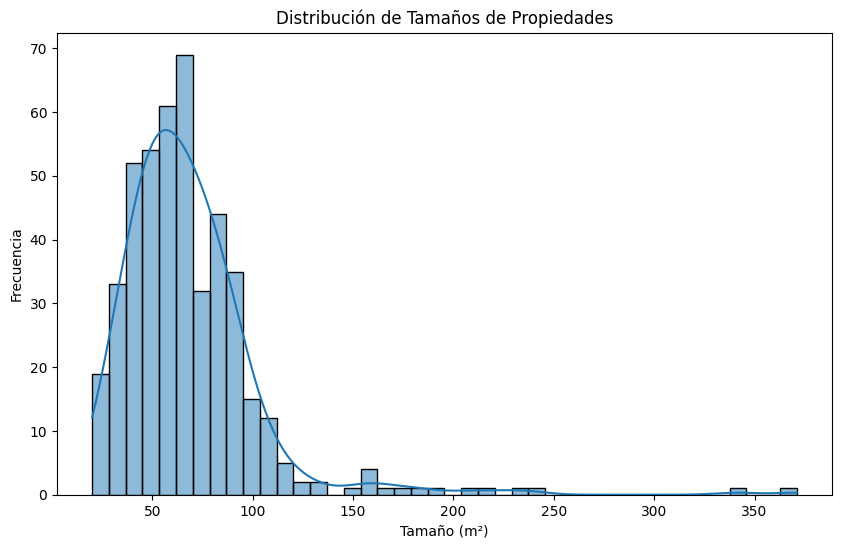

In [ ]:
# Distribucion del tamaño de las propiedades

plt.figure(figsize=(10, 6))
sns.histplot(df_limpio['size'], kde=True)
plt.title('Distribución de Tamaños de Propiedades')
plt.xlabel('Tamaño (m²)')
plt.ylabel('Frecuencia')
plt.show()

En este grafico vemos que la mayoría de las propiedades tienen tamaños que se agrupan alrededor de los 50-70 m².

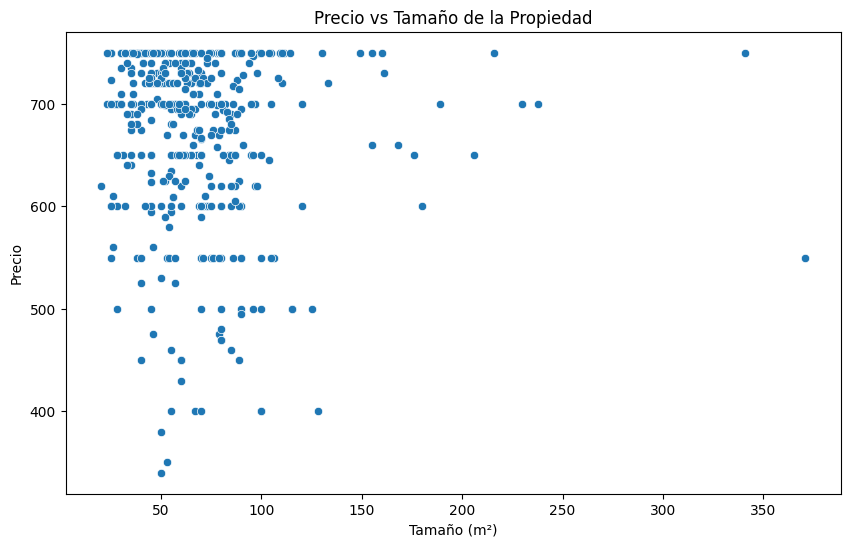

In [ ]:
# Relacion del Precio con Tamaño de la propiedad

plt.figure(figsize=(10, 6))
sns.scatterplot(x='size', y='price', data=df_limpio)
plt.title('Precio vs Tamaño de la Propiedad')
plt.xlabel('Tamaño (m²)')
plt.ylabel('Precio')
plt.show()

Observamos una considerable dispersion de los datos, lo que nos hace ver el tamaño no es el factor mas influyente a la hora de determinar el precio.

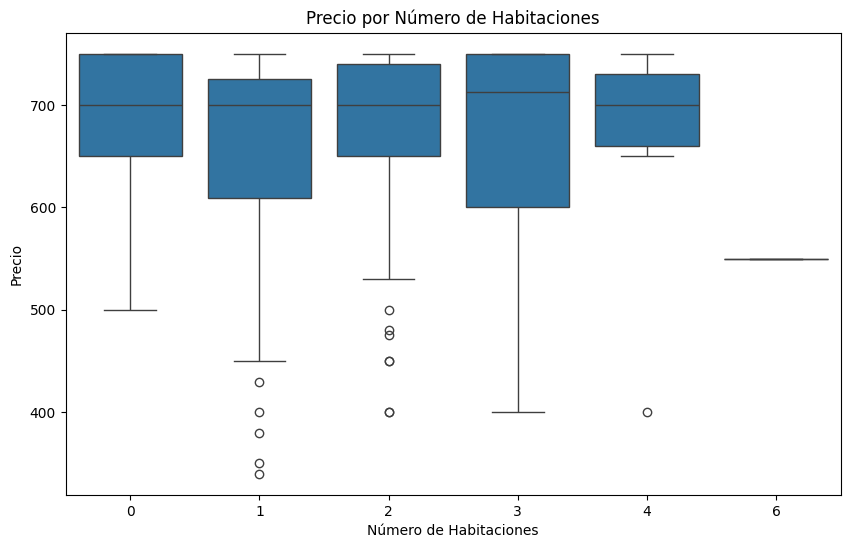

In [ ]:
# Relacion de Precio por Número de Habitaciones

plt.figure(figsize=(10, 6))
sns.boxplot(x='rooms', y='price', data=df_limpio)
plt.title('Precio por Número de Habitaciones')
plt.xlabel('Número de Habitaciones')
plt.ylabel('Precio')
plt.show()

Podemos ver que a medida que aumenta el numero de habitaciones, el precio promedio tambien tiende a aumentar. Vemos excepcion en los estudios, de 0 habitaciones, ya que suelen estar situados en el centro, donde como veremos luego, el precio es mas elevado.

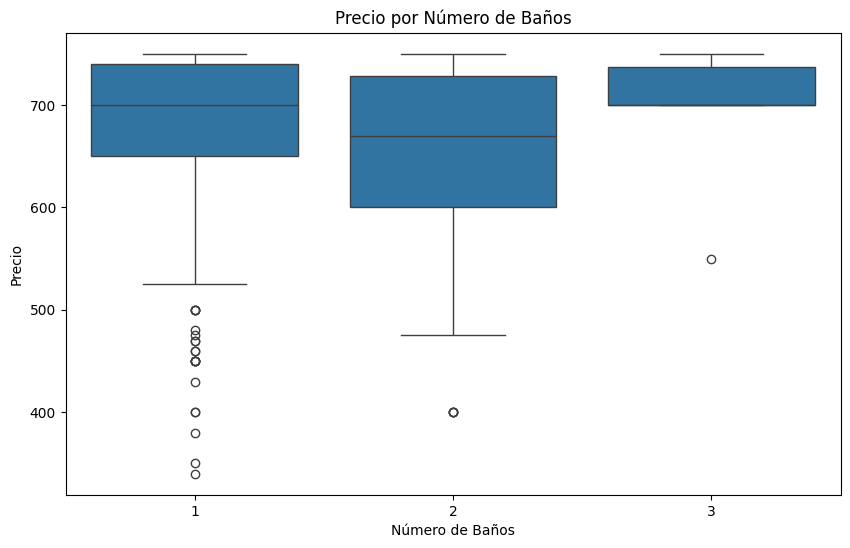

In [ ]:
# Precio por Número de Baños

plt.figure(figsize=(10, 6))
sns.boxplot(x='bathrooms', y='price', data=df_limpio)
plt.title('Precio por Número de Baños')
plt.xlabel('Número de Baños')
plt.ylabel('Precio')
plt.show()

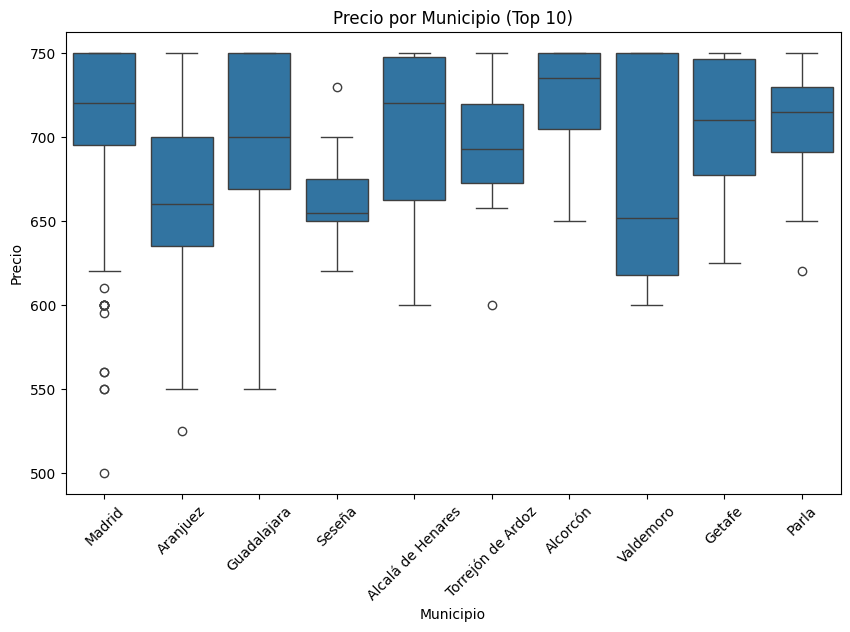

In [ ]:
# Precio por Municipio

plt.figure(figsize=(10, 6))
municipios_mas_comunes = df_limpio['municipality'].value_counts().index[:10]
df_filtrado = df_limpio[df_limpio['municipality'].isin(municipios_mas_comunes)]
sns.boxplot(x='municipality', y='price', data=df_filtrado)
plt.title('Precio por Municipio (Top 10)')
plt.xlabel('Municipio')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.show()

El municipio de Madrid presenta el precio medio mas alto, seguido de cerca por Alcalá de Henares y Alcorcón.

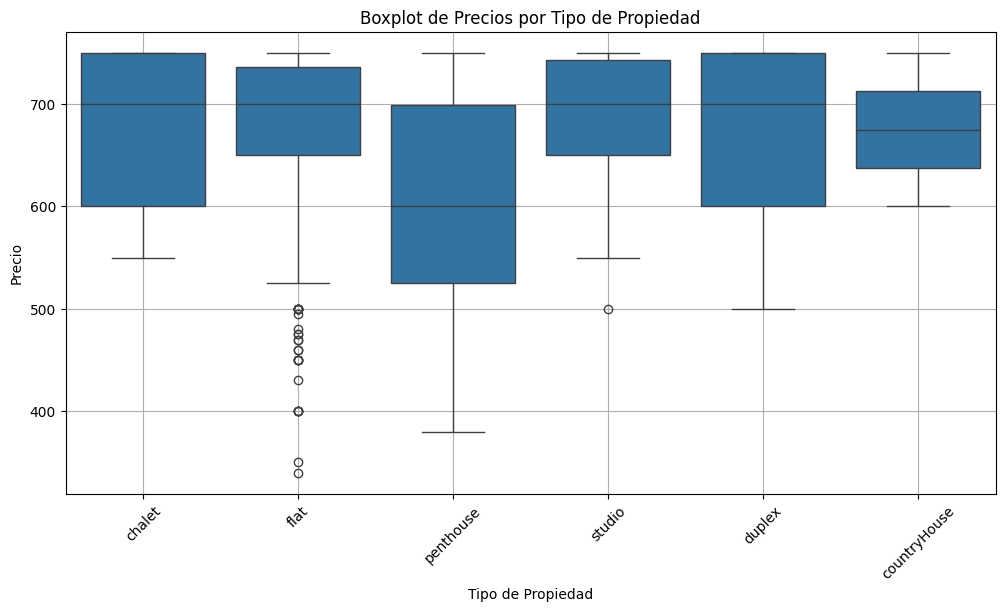

In [ ]:
# Relacion del Precio con el tipo de propiedad

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_limpio, x='propertyType', y='price')
plt.title('Precios por Tipo de Propiedad')
plt.xlabel('Tipo de Propiedad')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Podemos ver que chalets y duplex tienden a tener precios mas altos.

Es curioso que los aticos (penthouse) tengan un valor medio tan bajo, al contrario de lo que se podria pensar.

Esto se podria deber a problemas asociados a este tipo de viviendas como infiltraciones, problemas de aislamiento, costes adicionales de mantenimiento (terraza), percepcion negativa en cuanto a ruido y problemas de temperatura en verano e invierno. Todo esto puede hacer que disminuya la demanda y por tanto su precio de alquiler.

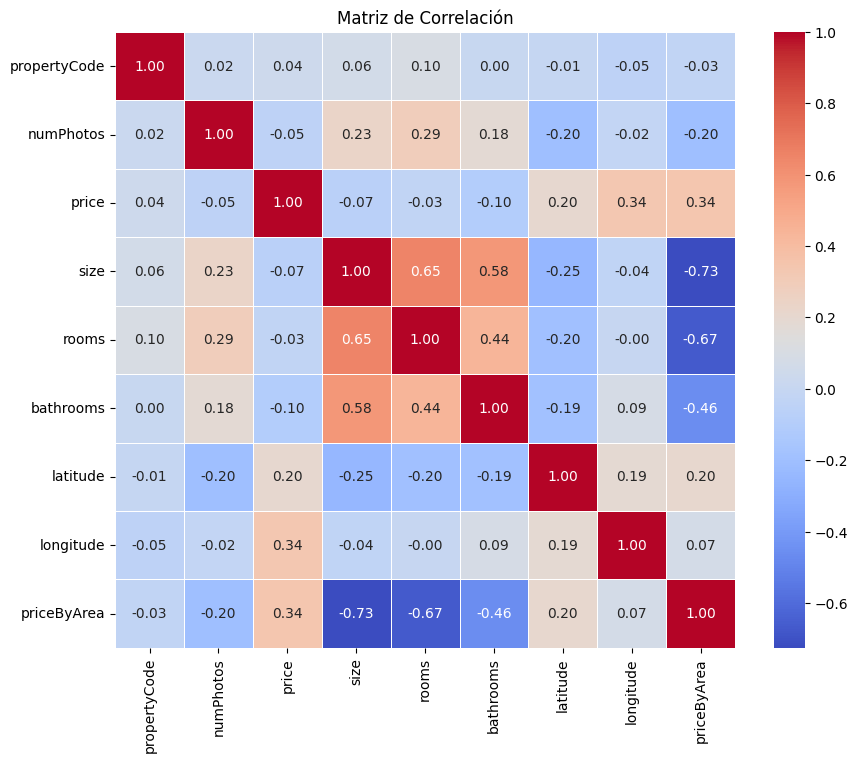

In [ ]:
# Correlacion entre variables

# Filtrar solo las columnas numéricas
numeric_columns = [
    'propertyCode', 'numPhotos', 'price', 'size',
    'rooms', 'bathrooms', 'latitude', 'longitude', 'priceByArea'
]

# Crear la matriz de correlación
correlation_matrix = df_limpio[numeric_columns].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()



Vemos que las varibles que mayor correlacion tienen son el tanto el numero de habitaciones, y de baños, con el tamaño. Cosa completamente logica.

Las variables que mayor relacion guardan con el precio son el precio por area y su latitud y longitud.

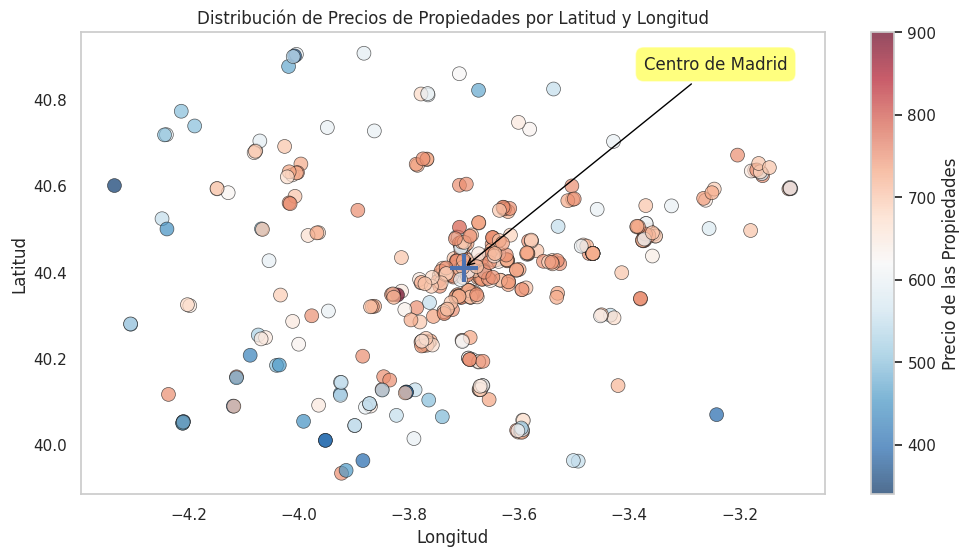

In [ ]:
# Relacion entre el precio y la ubicacion

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    df_limpio['longitude'],
    df_limpio['latitude'],
    c=df_limpio['price'],
    cmap='RdBu_r',  # Cambia la paleta de colores si lo deseas
    s=100,          # Tamaño de los puntos
    alpha=0.7,      # Transparencia de los puntos
    edgecolor='k',   # Color del borde de los puntos
    linewidths=0.5  # Ancho del borde de los puntos
)

# Añadir la marca para el centro de Madrid
madrid_lat, madrid_lon = 40.41, -3.70
plt.plot(madrid_lon, madrid_lat, 'b+', markersize=20, markeredgewidth=3, label='Centro de Madrid')

# Añadir una etiqueta para el centro de Madrid
plt.annotate(
    'Centro de Madrid',
    xy=(madrid_lon, madrid_lat),
    xytext=(0.95, 0.95),
    textcoords='axes fraction',
    ha='right',
    va='top',
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black')
)


plt.colorbar(scatter, label='Precio de las Propiedades')  # barra de color
plt.title('Distribución de Precios de Propiedades por Latitud y Longitud')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid()
plt.show()

En este grafico podemos ver la relacion entre el precio y la ubicacion.
Vemos que el precio aumenta a medida que se acerca al centro. Asi como un precio tambien mayor en las zonas norte y este.

In [ ]:
import geopandas as gpd

import folium
from folium import Choropleth, Circle, Marker, Icon, Map, GeoJson
from folium.plugins import HeatMap, MarkerCluster

Vamos a representar las casas en un mapa interactivo, dividiendolas por las que tienen parking (verde) y las que no tienen (rojo). A su vez si nos posicionamos sobre una de ellas, podemos ver su precio de alquiler.

In [ ]:
map_1 = Map(location=[40.32,-3.69], tiles='cartodbpositron', zoom_start=10)


for idx, row in df_limpio.iterrows():
    if(row.parkingSpace == True):
        Marker([row.latitude, row.longitude], popup=row.price ,icon = Icon(color='green',icon='ok-sign'),tooltip='Click me!').add_to(map_1)
    else:
        Marker([row.latitude, row.longitude], popup=row.price,icon = Icon(color='red',icon='exclamation-sign'),tooltip='Click me!').add_to(map_1)

In [ ]:
map_1

En el siguiente mapa podemos ver la distribucion en funcion del tipo de vivienda

chalet: azul

flat: verde

penthouse: morado

studio: naranja

duplex: rojo

countryHouse: azul oscuro

In [ ]:
# distribucion en funcion del tipo de casa

import folium
from folium import Marker, Icon

# Crear el mapa base
map_3 = folium.Map(location=[40.32, -3.69], tiles='cartodbpositron', zoom_start=10)

# Definir un diccionario para los colores de cada tipo de propiedad
property_colors = {
    'chalet': 'blue',
    'flat': 'green',
    'penthouse': 'purple',
    'studio': 'orange',
    'duplex': 'darkred',
    'countryHouse': 'darkblue'
}

# Iterar sobre el DataFrame y añadir marcadores
for idx, row in df_limpio.iterrows():
    # Determinar el color según el tipo de propiedad
    color = property_colors.get(row.propertyType, 'gray')  # 'gray' como color por defecto

    # Crear el marcador
    Marker(
        location=[row.latitude, row.longitude],
        popup=row.price,
        icon=Icon(color=color, icon='info-sign'),  # Cambiar el icono si es necesario
        tooltip='Click me!'
    ).add_to(map_3)

# Mostrar el mapa
map_3


Vamos a añadir en el mapa todos los hospitales que hay en Madrid y un circulo de 5 km a su alrededor para ver que casas estan dentro de esos rangos y cuales no.

In [ ]:
df_hospitales = pd.read_csv('/content/hospitales_coordenadas.csv', encoding='ISO-8859-1')

In [ ]:
df_hospitales.head()

,Nombre,Latitud,Longitud
0,Collado Villalba,40.655,-4.000
1,Escorial,40.607,-4.118
2,Infanta Sofia,40.558,-3.610
3,Principe Asturias,40.510,-3.347
4,Ramon y Cajal,40.487,-3.369


In [ ]:
from folium import Map, Marker, Circle, Icon

# Crear el mapa inicial
map_1 = Map(location=[40.32, -3.69], tiles='cartodbpositron', zoom_start=10)

# Añadir las casas al mapa
for idx, row in df_limpio.iterrows():
    Marker(
        [row.latitude, row.longitude],
        popup=row.price,
        icon=Icon(color='blue', icon='home'),  # Icono azul para todas las casas
        tooltip='Casa'
    ).add_to(map_1)

# Añadir los hospitales al mapa
for idx, row in df_hospitales.iterrows():
    # Crear un marcador para el hospital
    Marker(
        [row.Latitud, row.Longitud],
        popup=row.Nombre,  # Asumiendo que tienes una columna 'name' para el nombre del hospital
        icon=Icon(color='red', icon='square'),  # Icono cuadrado en rojo
        tooltip='Hospital'
    ).add_to(map_1)

    # Añadir un círculo de 5 km de radio alrededor del hospital
    Circle(
        location=[row.Latitud, row.Longitud],
        radius=5000,  # Radio en metros
        color='green',  # Color del círculo
        fill=True,
        fill_color='green',
        fill_opacity=0.2
    ).add_to(map_1)

# Mostrar el mapa
map_1


# VALORES ATIPICOS 'OUTLIERS'

En este analisis, he decidido mantener los valores atipicos identificados en las variables 'bathrooms', 'rooms', 'size'. Si bien estos valores se encuentran fuera del rango habitual, considero que representan propiedades con caracteristicas únicas que pueden influir de manera significativa en el precio del alquiler.
Ademas vamos a aplicar un modelo Random Forest, que son muy resistentes a los valores atipicos.
Por otro lado hice la prueba, tanto eliminando como tratando los outliers y el rendimiento del modelo fue notablemente mas bajo.

### **MODELO MACHINE LEARNING**

Ahora vamos a crear un modelo de Machine Learning que nos ayude a predecir el precio de alquiler de las viviendas.

In [ ]:
# Primero preparo un nuevo dataset con las columnas mas relevantes

df_modelo = df_limpio.loc[:, ['numPhotos', 'price', 'propertyType', 'size', 'exterior', 'rooms', 'municipality', 'status', 'priceByArea', 'hasLift', 'parkingSpace']]

df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   numPhotos     450 non-null    int64  
 1   price         450 non-null    float64
 2   propertyType  450 non-null    object 
 3   size          450 non-null    float64
 4   exterior      450 non-null    bool   
 5   rooms         450 non-null    int64  
 6   municipality  450 non-null    object 
 7   status        450 non-null    object 
 8   priceByArea   450 non-null    float64
 9   hasLift       450 non-null    bool   
 10  parkingSpace  450 non-null    bool   
dtypes: bool(3), float64(3), int64(2), object(3)
memory usage: 29.6+ KB


Primero voy a crear varios modelos de Machine Learning, para ver cual es mas preciso y empezar a trabajar sobre el.

In [ ]:
# Creacion varios modelos

# trato variables categoricas
categoricas = ['propertyType', 'municipality', 'status']
df_encoded = pd.get_dummies(df_modelo, columns=['propertyType', 'municipality', 'status'])

# trato variables numericas
numericas = ['numPhotos', 'size', 'rooms', 'priceByArea']
scaler = StandardScaler()
df_encoded[numericas] = scaler.fit_transform(df_encoded[numericas])

# divido X e Y
Xp = df_encoded.drop('price', axis=1)  # Variables predictoras
yp = df_encoded['price']               # Variable objetivo

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(Xp, yp, test_size=0.2, random_state=42)

# Entreno diferentes tipos de modelos de machine learning para ver cual tiene mejor resultado


# Modelo de Regresión Lineal
lr = LinearRegression()
lr.fit(X_train_p, y_train_p)
lr_train_score = lr.score(X_train_p, y_train_p)
lr_test_score = lr.score(X_test_p, y_test_p)
lr_mse = mean_squared_error(y_test_p, lr.predict(X_test_p))
lr_r2 = r2_score(y_test_p, lr.predict(X_test_p))
print("Regresión Lineal:")
print(f"R² de entrenamiento: {lr_train_score:.2f}")
print(f"R² de prueba: {lr_test_score:.2f}")
print(f"MSE de prueba: {lr_mse:.2f}")


# Modelo de Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_p, y_train_p)
rf_train_score = rf.score(X_train_p, y_train_p)
rf_test_score = rf.score(X_test_p, y_test_p)
rf_mse = mean_squared_error(y_test_p, rf.predict(X_test_p))
rf_r2 = r2_score(y_test_p, rf.predict(X_test_p))
print("\nRandom Forest:")
print(f"R² de entrenamiento: {rf_train_score:.2f}")
print(f"R² de prueba: {rf_test_score:.2f}")
print(f"MSE de prueba: {rf_mse:.2f}")


# Máquinas de Vector de Soporte
svm = SVR()
svm.fit(X_train_p, y_train_p)
svm_train_score = svm.score(X_train_p, y_train_p)
svm_test_score = svm.score(X_test_p, y_test_p)
svm_mse = mean_squared_error(y_test_p, svm.predict(X_test_p))
svm_r2 = r2_score(y_test_p, svm.predict(X_test_p))
print("\nMáquinas de Vector de Soporte:")
print(f"R² de entrenamiento: {svm_train_score:.2f}")
print(f"R² de prueba: {svm_test_score:.2f}")
print(f"MSE de prueba: {svm_mse:.2f}")

Regresión Lineal:
R^2 de entrenamiento: 0.83
R^2 de prueba: -22685053101031456505856.00
MSE de prueba: 121206899666037212698378240.00

Random Forest:
R^2 de entrenamiento: 0.97
R^2 de prueba: 0.71
MSE de prueba: 1569.94

Máquinas de Vector de Soporte:
R^2 de entrenamiento: -0.03
R^2 de prueba: -0.13
MSE de prueba: 6023.25


Vemos que el modelo que mejor resultado previo aporta es el modelo de Random Forest.

Vamos a intentar mejorar el modelo, primero buscaremos los mejores hiperparametros.

In [ ]:
# Mejores hiperparametros para mejorar el modelo
param_grid = ParameterGrid(
                {'n_estimators': [141],
                 'max_features': [100, 105, 110],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )


# Loop para ajustar un modelo con cada combinación de hiperparámetros
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:

    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelo.fit(X_train_p, y_train_p)

    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} ✓")


# Resultados
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

Modelo: {'max_depth': None, 'max_features': 100, 'n_estimators': 141} ✓
Modelo: {'max_depth': None, 'max_features': 105, 'n_estimators': 141} ✓
Modelo: {'max_depth': None, 'max_features': 110, 'n_estimators': 141} ✓
Modelo: {'max_depth': 3, 'max_features': 100, 'n_estimators': 141} ✓
Modelo: {'max_depth': 3, 'max_features': 105, 'n_estimators': 141} ✓
Modelo: {'max_depth': 3, 'max_features': 110, 'n_estimators': 141} ✓
Modelo: {'max_depth': 10, 'max_features': 100, 'n_estimators': 141} ✓
Modelo: {'max_depth': 10, 'max_features': 105, 'n_estimators': 141} ✓
Modelo: {'max_depth': 10, 'max_features': 110, 'n_estimators': 141} ✓
Modelo: {'max_depth': 20, 'max_features': 100, 'n_estimators': 141} ✓
Modelo: {'max_depth': 20, 'max_features': 105, 'n_estimators': 141} ✓
Modelo: {'max_depth': 20, 'max_features': 110, 'n_estimators': 141} ✓


,oob_r2,max_depth,max_features,n_estimators
1,0.758770,NaN,105.0,141.0
2,0.757747,NaN,110.0,141.0
11,0.755702,20.0,110.0,141.0
10,0.755463,20.0,105.0,141.0


Una vez tenemos los Hiperparametros que mejor se adaptan, vamos a crear una pipeline para tratar las variables tanto numericas como categoricas.

In [ ]:
# Separo las variables predictoras y la variable objetivo

X = df_modelo.drop('price', axis=1)
y = df_modelo['price']


# columnas numéricas y categóricas
numeric_features = ['numPhotos', 'size', 'rooms', 'priceByArea']
categorical_features = ['propertyType', 'exterior', 'municipality', 'status', 'hasLift', 'parkingSpace']


# Creo preprocesadores para variables numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Combino preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Creo el pipeline con el preprocesador y el modelo Random Forest con los parámetros especificados
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=141,
        max_depth=None,
        max_features=100,
        random_state=42
    ))
])


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el modelo
rf_pipeline.fit(X_train, y_train)

# Evaluar el modelo
train_score = rf_pipeline.score(X_train, y_train)
test_score = rf_pipeline.score(X_test, y_test)

print(f"R² en conjunto de entrenamiento: {train_score:.4f}")
print(f"R² en conjunto de prueba: {test_score:.4f}")

R² en conjunto de entrenamiento: 0.9683
R² en conjunto de prueba: 0.6967


Vamos a seguir intentando mejorar el modelo, esta vez aplicando la validacion cruzada.

In [ ]:
# Validacion cruzada
cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='r2')

print("Resultados de la validación cruzada (R²):")
print(f"Media: {cv_scores.mean():.4f}")
print(f"Desviación estándar: {cv_scores.std():.4f}")

# Calcular RMSE usando validación cruzada
def rmse_score(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(mean_squared_error(y, y_pred))

rmse_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring=rmse_score)

print("\nResultados de la validación cruzada (RMSE):")
print(f"Media: {rmse_scores.mean():.2f}")
print(f"Desviación estándar: {rmse_scores.std():.2f}")

Resultados de la validación cruzada (R²):
Media: 0.7575
Desviación estándar: 0.0851

Resultados de la validación cruzada (RMSE):
Media: 41.21
Desviación estándar: 12.28


Seguimos intentando mejorar el modelo esta vez con la selección de características. Se utiliza RFECV (Recursive Feature Elimination with Cross-Validation) para seleccionar las características más relevantes.

Utilizaremos tambien una validación cruzada repetida para obtener una estimacion mas estable del rendimiento del modelo

In [ ]:
# características despues del preprocesamiento
X_train_preprocessed = rf_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = rf_pipeline.named_steps['preprocessor'].transform(X_test)

# selección de caracteristicas usando RFECV
rf_model = rf_pipeline.named_steps['regressor']
selector = RFECV(estimator=rf_model, step=1, cv=5, scoring='r2')
selector = selector.fit(X_train_preprocessed, y_train)

# aplicar la seleccion de características
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

print(f"Número de características seleccionadas: {X_train_selected.shape[1]}")

# validacion cruzada repetida
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(rf_model, X_train_selected, y_train, cv=rkf, scoring='r2')

print(f"Puntaje promedio de validación cruzada: {scores.mean():.4f}")

# entrenamiento final con las características seleccionadas
rf_model.fit(X_train_selected, y_train)

# evaluación en el conjunto de prueba
y_pred = rf_model.predict(X_test_selected)
rf_train_score = rf_model.score(X_train_selected, y_train)
rf_test_score = rf_model.score(X_test_selected, y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"R² en entrenamiento: {rf_train_score:.4f}")
print(f"R² en prueba: {rf_test_score:.4f}")
print(f"MSE en prueba: {mse:.4f}")

# comparación con el modelo original
print("\nComparación con el modelo original:")
print(f"R² original en entrenamiento: {train_score:.4f}")
print(f"R² original en prueba: {test_score:.4f}")


Número de características seleccionadas: 2
Puntaje promedio de validación cruzada: 0.8684
R2 en entrenamiento: 0.9675
R2 en prueba: 0.8516
MSE en prueba: 792.9094

Comparación con el modelo original:
R2 original en entrenamiento: 0.9683
R2 original en prueba: 0.6967


Vemos como la precision de nuestro modelo ha aumentado del 0.69 inicial, al 0.85.

Ahora vamos a realizar la prediccion del precio de alquiler de una vivienda con las siguientes caracteristicas.

In [ ]:
datos_prueba = pd.DataFrame({
    'numPhotos': [10],
    'propertyType': ['apartment'],
    'size': [90.0],
    'exterior': [True],
    'rooms': [3],
    'municipality': ['Madrid'],
    'status': ['good'],
    'priceByArea': [13.0],
    'hasLift': [True],
    'parkingSpace': [False]
})

# Preprocesar los datos de ejemplo
ejemplo_preprocessed = preprocessor.transform(datos_prueba)

# Aplicar la selección de características
ejemplo_selected = selector.transform(ejemplo_preprocessed)

# Realizar la predicción
prediccion = rf_model.predict(ejemplo_selected)

print(f"El precio predicho para la vivienda es: {prediccion[0]:.2f} €")

El precio predicho para la vivienda es: 766.89 €


Guardo el modelo como: 'prediccion_alquiler_madrid'

In [ ]:
# Guardo el modelo

import joblib

joblib.dump(rf_model, 'prediccion_alquiler_madrid.joblib')
print("Modelo guardado como 'prediccion_alquiler_madrid.joblib'")

Modelo guardado como 'prediccion_alquiler_madrid.joblib'
